In [1]:
import spacy
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.utils import simple_preprocess
import zipfile
import pickle
from tensorflow import keras
from keras.models import load_model
import numpy as np
import re
from tensorflow.keras import layers
from nltk.corpus import stopwords
import nltk
import tqdm

# load the pre-trained English language model
nlp = spacy.load('en_core_web_sm')

# nltk.download('stopwords')

pattern = re.compile('.*-(MONEY|QUANTITY|PERCENT|ORDINAL|DATE|TIME|CARDINAL)|Other|O')
pattern_symbols = re.compile('^[\.\\\/\[\]\(\),\-\'\"\?\!\“\”\’@:;–]+$')

stop_words = set(stopwords.words("english"))
stop_words = stop_words.union({"reuters", "bbc"})

In [2]:
# import sys
# !{sys.executable} -m pip install pyLDAvis

## Text and files preprocessing

In [3]:
def remove_prefix(label):
    return label.split('-')[-1]

In [4]:
def split_text(text):
    sentences = nltk.sent_tokenize(text)
    return [nltk.word_tokenize(sentence) for sentence in sentences]

In [5]:
def remove_stopwords(tokens):
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words and len(token)>3]
    filtered_tokens = [token for token in filtered_tokens if not pattern_symbols.match(token.lower())]
    return filtered_tokens

In [6]:
def process_file(file, filename, texts):
    content = file.read(filename)
    if type(content) == bytes:
        text = content.decode('utf-8')
        texts.append(text)

    if len(content.strip()) == 0:
        print("No text was found")
        return

In [7]:
def preprocess_text(text, word2idx, max_len):
    # Split the text into tokens
    sentences = split_text(text)

    # Convert the tokens to integer IDs using the word2id dictionary
    ids = []
    endpad_idx = word2idx['ENDPAD']
    for tokens in sentences:
        array = []
        for token in tokens:
            if token in word2idx.keys():
                array.append(word2idx[token])
            else:
                array.append(0)

        while len(array) < max_len:
            array.append(endpad_idx)
        ids.append(array)

    return ids, sentences

In [8]:
def predict_text(text, model):
    ents = []
    for i in range(len(sentences := split_text(text))):
        doc = nlp(' '.join(sentences[i]))
        ents_pred = [ent.text for ent in doc.ents]
        for word in sentences[i]:
            if len(word) > 3:
                ents.append(word.lower())
                if word in ents_pred:
                    # append the same word once more to increase its statistics and weight artificially
                    ents.append(word.lower())
#                     ents.append(word.lower())
    ents = remove_stopwords(ents)
    return ents

def predict_text_2(text, model, tags):
    ents = []
    labels = []
    for i in range(len(text)):
        p = model.predict(np.array([text[0][i]]), verbose=0)
        p = np.argmax(p, axis=-1)
        for idx, pred in enumerate(p[0][0:len(text[1][i])]):
            if len(word := text[1][i][idx]) > 3:
                if not pattern.match(tags[pred]):
                    ents.append(word.lower())
                    # append the same word once more to increase its statistics and weight artificially
#                     ents.append(word.lower())
#                     ents.append(word.lower())
                    labels.append(tags[pred])
    ents = remove_stopwords(ents)
    return ents, labels

In [9]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_tokens

def get_labeled_words(model, texts, word2idx):
    proc_labels = []
    proc_ents = []
    entity_clusters = {}
    for text in texts:
        processed = preprocess_text(text, word2idx, model.layers[0].output_shape[0][1])
        ents, labels = predict_text_2(processed, model, tags)
        for ent, label in zip(set(ents), labels):
            if not pattern.match(label):
                if (label := remove_prefix(label)) not in entity_clusters and not ent.lower() in stop_words and not pattern_symbols.match(ent.lower()):
                    entity_clusters[label] = []
                else:
                    entity_clusters[label].append(ent.lower())
        proc_ents.append(remove_stopwords(ents))
        proc_labels.append(labels)
    lemmatized_text = [lemmatize_tokens(doc) for doc in proc_ents]
    return lemmatized_text, proc_labels, entity_clusters

def get_labeled_words_2(texts):
    proc_labels = []
    proc_ents = []
    for text in texts:
        processed = split_text(text)
        ents = [word for sentence in processed for word in sentence]

        proc_ents.append(remove_stopwords(ents))
    lemmatized_text = [lemmatize_tokens(doc) for doc in proc_ents]
    return lemmatized_text

## Transformer-related functions

In [10]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        query = tf.reshape(
            tf.transpose(tf.reshape(query, (batch_size, -1, self.num_heads, self.head_dim)), perm=[0, 2, 1, 3]),
            (batch_size * self.num_heads, -1, self.head_dim),
        )
        key = tf.reshape(
            tf.transpose(tf.reshape(key, (batch_size, -1, self.num_heads, self.head_dim)), perm=[0, 2, 1, 3]),
            (batch_size * self.num_heads, -1, self.head_dim),
        )
        value = tf.reshape(
            tf.transpose(tf.reshape(value, (batch_size, -1, self.num_heads, self.head_dim)), perm=[0, 2, 1, 3]),
            (batch_size * self.num_heads, -1, self.head_dim),
        )

        attention_logits = tf.matmul(query, key, transpose_b=True)
        attention_logits = attention_logits / tf.math.sqrt(tf.cast(self.head_dim, tf.float32))
        attention_weights = tf.nn.softmax(attention_logits, axis=-1)

        output = tf.matmul(attention_weights, value)
        output = tf.reshape(
            tf.transpose(tf.reshape(output, (batch_size, self.num_heads, -1, self.head_dim)), perm=[0, 2, 1, 3]),
            (batch_size, -1, self.embed_dim),
        )
        output = self.combine_heads(output)
        return output

In [11]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()

        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output)
        ffn_output = self.ffn(attn_output)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(inputs + ffn_output)

In [12]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings

In [13]:
class NERModel(keras.Model):
    def __init__(
        self, num_tags, vocab_size, maxlen=128, embed_dim=32, num_heads=2, ff_dim=32, num_layers=1, rate=0.1
    ):
        super().__init__()
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
#         self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
        self.dropout1 = layers.Dropout(0.1)
        self.ff = layers.Dense(ff_dim, activation="relu")
        self.ff_final = layers.Dense(num_tags, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        x = self.dropout1(x, training=training)
        x = self.ff(x)
        x = self.ff_final(x)
        return x

## Experiments

In [19]:
texts = []
with zipfile.ZipFile("../data/articles_2021-11-05_1000.zip", "r") as f:
# with zipfile.ZipFile("../data/articles_2023-01-07_2000.zip", "r") as f:
# with zipfile.ZipFile("../data/articles_2023-02-04_500.zip", "r") as f:
# with zipfile.ZipFile("../data/articles_2023-02-09_1000.zip", "r") as f:
    total_f = len(f.namelist())
    counter = 1
    for filename in f.namelist():
        counter += 1
        process_file(f, filename, texts)
    f.close()

# my_model5
# model_general_lstm/model.h5
# model_general_transformer/model
model = load_model('../models/model_general_lstm/model.h5')

# with open('../models/model_general_transformer/params.pickle', 'rb') as handle:
#     tmp = pickle.load(handle)
#     num_tags = tmp[0]
#     len_words = tmp[1]
# model = NERModel(num_tags, len_words, embed_dim=128, num_heads=2, ff_dim=num_tags*4, num_layers=2, rate=0.2)
# model.load_weights('../models/model_general_transformer/model')
# ----------------------------#
with open('../models/model_general_transformer/tags.pickle', 'rb') as handle:
    tags = pickle.load(handle)

with open('../models/model_general_transformer/words.pickle', 'rb') as handle:
    word2idx = pickle.load(handle)


proc_ents, proc_labels, entity_clusters = get_labeled_words(model, texts, word2idx)

# proc_ents = get_labeled_words_2(texts)

print("Done")

Done


In [20]:
print(entity_clusters.keys())

dict_keys(['org', 'gpe', 'geo', 'eve', 'per', 'nat'])


In [21]:
# Create a dictionary mapping named entities to integer ids
dictionary = Dictionary(proc_ents)

# Create a document-term matrix where each document is a text and each term is a named entity
corpus = [dictionary.doc2bow(text) for text in proc_ents]

In [22]:
import copy

corpus_extended = copy.deepcopy(corpus)
corpus_len = len(corpus)
print(int(corpus_len*0.005))

# Add named entities to dictionary and corpus
for entity_type, entities in entity_clusters.items():
    if len(entities) > 5:
        processed_ents = [entity.lower() for entity in set(entities)]
        new_doc = [dictionary.doc2bow(simple_preprocess(entity)) for entity in processed_ents]
        new_doc = [item for entity in new_doc for item in entity]
        for i in range(int(corpus_len*0.005)):
            corpus_extended.append(new_doc)

print(len(corpus), len(corpus_extended))


5
1000 1030


In [23]:
# import wandb
# from sklearn.metrics.pairwise import cosine_similarity

# # Define the hyperparameters to sweep over
# sweep_config = {
#     'name': 'NER_NLP_med',
#     'method': 'grid',
#     'metric': {
#         'name': 'tus_score',
#         'goal': 'maximize'
#     },
#     'parameters': {
#         'num_topics': {'values': [3, 4, 6, 8, 10]},
#         'passes': {'values': [10]},
#         'iterations': {'values': [200]},
#         'alpha': {'values': ['symmetric', 'asymmetric']}
#     }
# }

# # corpus_data = corpus
# corpus_data = corpus_extended

# # Define the training function
# def train():
    
#     wandb.init()

#     # Set the hyperparameters based on the wandb configuration
#     num_topics = wandb.config.num_topics
#     passes = wandb.config.passes
#     iterations = wandb.config.iterations
#     alpha = wandb.config.alpha

#     # Create the LDA model
#     lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus_data,
#                                 id2word=dictionary,
#                                 num_topics=num_topics,
#                                 workers=19,
#                                 random_state=100,
#                                 chunksize=100,
#                                 passes=passes,
#                                 iterations=iterations,
#                                 alpha=alpha,
#                                 per_word_topics=False
#                                 )

#     # Compute coherence and perplexity
#     coherence_model = CoherenceModel(model=lda_model,
#                                      corpus=corpus_data,
#                                      coherence='u_mass')
#     coherence = coherence_model.get_coherence()

#     perplexity = lda_model.log_perplexity(corpus_data)

#     tus_score = calculate_tus(lda_model)
    
#     # Log the results to wandb
#     wandb.log({
#         'coherence(U_mass)': coherence,
#         'perplexity': perplexity,
#         'tus_score': tus_score[1]
#     })

#     wandb.finish()

# # Run the agent to sweep over the hyperparameters
# sweep_id = wandb.sweep(sweep_config, project='NER_NLP_med')

# wandb.agent(sweep_id, function=train)

In [24]:
def train_lda(corpus, num_topics):
    # Create the LDA model
    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                id2word=dictionary,
                                num_topics=num_topics,
                                workers=19,
                                random_state=100,
                                chunksize=100,
                                passes=10,
                                iterations=200,
                                alpha='symmetric',
                                per_word_topics=False
                                )
    return lda_model

In [25]:
# used_corpus = corpus
# # used_corpus = corpus_extended
# num_topics = 4
# lda_model = train_lda(used_corpus, num_topics)

In [26]:
from scipy.spatial import distance

def calc_hausdorff_distance(model):
    num_topics = model.num_topics
    hd_matrix = np.zeros((num_topics, num_topics))  # Initialize a matrix to store HD values
    
    for i in range(num_topics):
        for j in range(i+1, num_topics):
            # extract topic distributions for topics i and j
            topic_i_dist = model.get_topic_terms(topicid=i)
            topic_j_dist = model.get_topic_terms(topicid=j)

            # compute asymmetric Hausdorff distance (HD) by saving the biggest of the two
            hd = max(distance.directed_hausdorff(topic_i_dist, topic_j_dist), 
                      distance.directed_hausdorff(topic_j_dist, topic_i_dist))

            hd_matrix[i, j] = hd[0]

    return np.mean(hd_matrix)

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_tus(model):
    """
    Calculate Topic Uniqueness Score (TUS) for each topic in a given LDA model.
    Returns an array of TUS scores and a mean TUS score for a model.
    The lower TUS score means that topics are less similar <-> more unique.
    """
    words_num = len(model.id2word)
#     words_num = 100
    num_topics = model.num_topics
    word_probs = np.zeros((num_topics, words_num))
    for topic_id in range(num_topics):
        word_probs[topic_id, :] = np.array([p for _, p in model.get_topic_terms(topic_id, words_num)])
    
    similarities = cosine_similarity(word_probs)
    np.fill_diagonal(similarities, 0) # set diagonal to 0 so a topic is not compared with itself
    tus_scores = np.mean(similarities, axis=1)
    tus_mean = np.mean(tus_scores)
    return tus_scores, tus_mean

# tus_scores, tus_mean = calculate_tus(lda_model)
# print(tus_scores)
# print(tus_mean)


In [28]:
# The same one as in the test_environment.py
def progress_bar(iteration, total):
    total_len = 100
    percent_part = ("{0:.2f}").format(100 * (iteration / total))
    filled = int(total_len * iteration / total)
    bar = '█' * filled + '-' * (total_len - filled)
    print(f'\r Progress: [{bar}] {percent_part}%', end='')
    if iteration == total:
        print()

In [36]:
results = {}
corpuses = {"classic corpus": corpus, "extended corpus": corpus_extended}
num_topics_arr = [5, 10, 15, 20]

def do_test(tus=True):
    total_iter = len(corpuses) * len(num_topics_arr)
    curr_iter = 1
    for key in corpuses:
        results[key] = {}
        for num_topics in num_topics_arr:
            progress_bar(curr_iter, total_iter)
            lda_model = train_lda(corpuses[key], num_topics)
            if tus:
                _, score = calculate_tus(lda_model)
            else:
                score = calc_hausdorff_distance(lda_model)
            results[key][str(num_topics)] = score
            curr_iter += 1

# test_tus = True
test_tus = False
do_test(test_tus)

 Progress: [████████████████████████████████████████████████████████████████████████████████████████████████████] 100.00%


In [37]:
results

{'classic corpus': {'5': 333.9200000021259,
  '10': 348.46000000166924,
  '15': 402.67555555872303,
  '20': 490.5400000051952},
 'extended corpus': {'5': 329.7600000009613,
  '10': 343.25000000616325,
  '15': 492.17777778231743,
  '20': 673.2925000061281}}

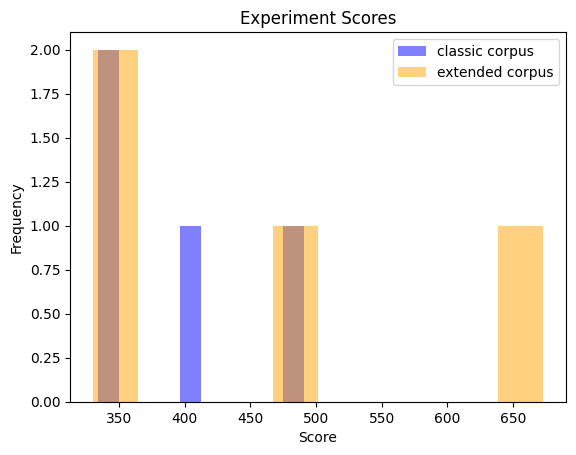

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for i, (key, value) in enumerate(results.items()):
    ax.hist(list(value.values()), bins=10, alpha=0.5, label=key, color=['blue', 'orange'][i])
    
ax.set_xlabel('Score')
ax.set_ylabel('Frequency')
ax.set_title('Experiment Scores')
ax.legend(loc='upper right')

plt.show()

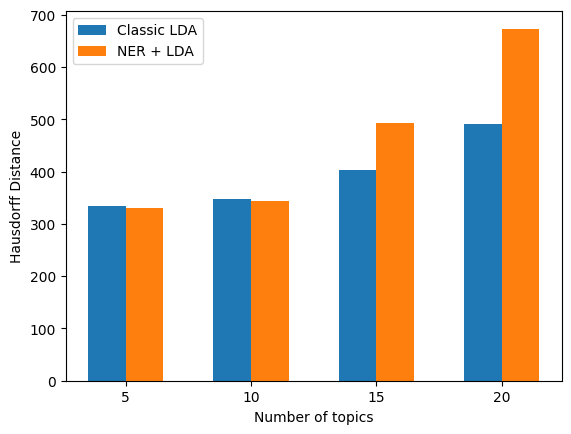

In [39]:
data = {'classic': {'a': 1, 'b': 2, 'c': 3}, 'new': {'a': 3, 'b': 4, 'c': 5}}



classic_keys = list(results['classic corpus'].keys())
extended_keys = list(results['extended corpus'].keys())

classic_values = list(results['classic corpus'].values())
extended_values = list(results['extended corpus'].values())

x_values = range(len(classic_keys))

bar_width = 0.3

# plot the bars for the classic dictionary values
plt.bar(x_values, classic_values, align='edge', width=-bar_width, alpha=1, label='Classic LDA')

# plot the bars for the new dictionary values
plt.bar(x_values, extended_values, align='edge', width=bar_width, alpha=1, label='NER + LDA')

# set the x-axis ticks and labels
plt.xticks(x_values, classic_keys)

# add a legend to the plot
plt.legend()

Y_str = "TUS" if test_tus else "Hausdorff Distance" 

# set the y-axis label
plt.ylabel(Y_str)

# set the x-axis label
plt.xlabel('Number of topics')

# show the plot
plt.show()